# GP Project: Dynamic Sign Langauge Translator
 
### Table of Contents
<ol>
<li><a href="#1">Import and Install Dependencies</a></li>
<li><a href="#2">Keypoints using MP Holistic</a></li>
<li><a href="#3">Extract Keypoint Values</a></li>
<li><a href="#4">Setup Folders for Collection</a></li>
<li><a href="#5">Collect Keypoint Values for Training and Testing</a></li>
<li><a href="#6">Preprocess Data and Create Labels and Features</a></li>
<li><a href="#7"> Build and Train LSTM Neural Network</a></li>
<li><a href="#8">Make Predictions</a></li>
<li><a href="#9">Save Weights</a></li>
<li><a href="#10">Evaluation using Confusion Matrix and Accuracy</a></li>
<li><a href="#11">Test in Real Time</a></li>    
</ol>

<a id='1'></a>

## 1. Import and Install Dependencies

In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [1]:
#run
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

<a id='2'></a>
## 2. Keypoints using MP Holistic

In [2]:
#run
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
#run
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
#run
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [5]:
# FOR TEST
# cap = cv2.VideoCapture(0)
# # Set mediapipe model 
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():

#         # Read feed
#         ret, frame = cap.read()

#         # Make detections
#         image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
#         # Draw landmarks
#         draw_styled_landmarks(image, results)

#         # Show to screen
#         cv2.imshow('Dynamic sign langauge translator', image)

#         # Break gracefully
#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break
#     cap.release()
#     cv2.destroyAllWindows()

In [6]:
# draw_styled_landmarks(frame, results)

In [7]:
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

<a id='3'></a>

## 3. Extract Keypoint Values

In [8]:
# len(results.pose_landmarks.landmark)   #33 key points with 4 parms

In [9]:
# len(results.right_hand_landmarks.landmark)    #21 key points with 3 parms same goes for left hand

In [5]:
#run
# extract all the landmarks and flatten them so we can enter it to the  then concate them in one single array
# the if codition handel the the part are not the frame so return a zero array with the length of the original landmark array
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [11]:
# result_test = extract_keypoints(results)

In [12]:
# result_test

<a id='4'></a>

## 4. Setup Folders for Collection

#### we will have for example 3 actions --> in every action we will have 30 video and --> in each video we will have 30 frame and--> in each frame will contain 258 landmark values (33*4  + 21*3 + 21*3 = 258)

>#### **Action Detection**
A key difference between action detection and other computer vision tasks is that a sequence of data rather than a single frame is used for detection.


In [9]:
#run
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(["أسمك ايه ؟","الحمد لله تمام","بتشتغل إيه ؟","بكام فلوس"
                     ,"تيجي معايا ؟","جيران" ,"صديق","عائلة","عريس","مشاء الله","مع السلامة","وحشتني"])

# 60 videos of data 
no_sequences = 60

# Videos are going to be 60 frames in length
sequence_length = 60

# Folder start
start_folder = 60

In [10]:
#run
# loop to make directories
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

<a id='5'></a>

## 5. Collect Keypoint Values for Training and Testing

In [ ]:
#run
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences or videos
        for sequence in range(no_sequences):
            # Loop through video length or sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)   
                #print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(3000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

<a id='6'></a>

## 6. Preprocess Data and Create Labels and Features

In [11]:
#run
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
#run
label_map = {label:num for num, label in enumerate(actions)}

In [13]:
label_map

{'أسمك ايه ؟': 0,
 'الحمد لله تمام': 1,
 'بتشتغل إيه ؟': 2,
 'بكام فلوس': 3,
 'تيجي معايا ؟': 4,
 'جيران': 5,
 'صديق': 6,
 'عائلة': 7,
 'عريس': 8,
 'مشاء الله': 9,
 'مع السلامة': 10,
 'وحشتني': 11}

In [14]:
#run
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [15]:
np.array(sequences).shape

(720, 60, 258)

In [16]:
np.array(labels).shape

(720,)

In [17]:
X = np.array(sequences)

In [18]:
X.shape

(720, 60, 258)

In [19]:
y = to_categorical(labels).astype(int)

In [20]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [21]:

# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = True, random_state = 8)


In [22]:
# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

In [23]:
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("y val shape: {}".format(y_val.shape))

X_train shape: (432, 60, 258)
X_test shape: (144, 60, 258)
X_val shape: (144, 60, 258)
y_train shape: (432, 12)
y_test shape: (144, 12)
y val shape: (144, 12)


<a id='7'></a>

## 7. Build and Train LSTM Neural Network

In [24]:
#run
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import TensorBoard

In [25]:
# log_dir = os.path.join('Logs')
# tb_callback = TensorBoard(log_dir=log_dir)

In [26]:
#run
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(60,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [29]:
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [27]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [28]:
model.fit(X_train, y_train, epochs=600,verbose=1, validation_data=(X_val,y_val))

Epoch 1/600
14/14 [==============================] - 11s 278ms/step - loss: 22.2616 - categorical_accuracy: 0.0833 - val_loss: 172.1446 - val_categorical_accuracy: 0.0764
Epoch 2/600
14/14 [==============================] - 3s 207ms/step - loss: 1866.2516 - categorical_accuracy: 0.0856 - val_loss: 6825.8188 - val_categorical_accuracy: 0.0625
Epoch 3/600
14/14 [==============================] - 3s 209ms/step - loss: 23322.4902 - categorical_accuracy: 0.0602 - val_loss: 92716.4297 - val_categorical_accuracy: 0.0694
Epoch 4/600
14/14 [==============================] - 3s 206ms/step - loss: 69549.7812 - categorical_accuracy: 0.0833 - val_loss: 101676.8125 - val_categorical_accuracy: 0.0417
Epoch 5/600
14/14 [==============================] - 3s 204ms/step - loss: 111610.9609 - categorical_accuracy: 0.0833 - val_loss: 147834.5312 - val_categorical_accuracy: 0.0972
Epoch 6/600
14/14 [==============================] - 3s 204ms/step - loss: 273773.9375 - categorical_accuracy: 0.0764 - val_loss

Epoch 49/600
14/14 [==============================] - 5s 332ms/step - loss: 2.4823 - categorical_accuracy: 0.0926 - val_loss: 2.4945 - val_categorical_accuracy: 0.0972
Epoch 50/600
12/14 [========================>.....] - ETA: 0s - loss: 2.4817 - categorical_accuracy: 0.0911

KeyboardInterrupt: 

In [ ]:
model.summary()

<a id='8'></a>

## 8. Make Predictions

In [25]:
res = model.predict(X_test)
res

array([[2.5355101e-07, 9.7997781e-07, 8.2057305e-02, ..., 1.4995623e-01,
        5.8339792e-05, 1.0096792e-02],
       [9.8141882e-06, 4.2145115e-07, 2.2186585e-02, ..., 7.3715663e-01,
        2.1331776e-04, 2.6019787e-02],
       [5.0712086e-04, 1.4224049e-03, 1.1061976e-03, ..., 4.2808615e-03,
        7.6259784e-03, 9.4821380e-04],
       ...,
       [3.2142566e-06, 3.4888210e-11, 9.4687760e-02, ..., 1.3324629e-05,
        4.7632422e-08, 6.8179106e-06],
       [8.8881934e-06, 3.1217940e-03, 9.8719496e-01, ..., 6.5318670e-04,
        2.4835099e-06, 5.3225212e-05],
       [4.1449632e-02, 9.1528487e-01, 6.1452128e-03, ..., 6.6854298e-04,
        8.1373117e-04, 3.1751109e-04]], dtype=float32)

In [28]:
actions[np.argmax(res[100])]

'مع السلامة'

In [29]:
actions[np.argmax(y_test[100])]

'مع السلامة'

<a id='9'></a>

## 9. Save Weights

In [30]:
model.save('DynamicModel.h5')

In [31]:
model.load_weights('DynamicModel.h5')

<a id='10'></a>

## 10. Evaluation using Confusion Matrix and Accuracy

In [32]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [33]:
yhat = model.predict(X_test)

In [34]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [35]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[132,   0],
        [  0,  12]],

       [[130,   2],
        [  0,  12]],

       [[131,   2],
        [  2,   9]],

       [[128,   2],
        [  2,  12]],

       [[131,   0],
        [  2,  11]],

       [[127,   5],
        [  0,  12]],

       [[131,   2],
        [  5,   6]],

       [[130,   2],
        [  0,  12]],

       [[123,   5],
        [  7,   9]],

       [[135,   3],
        [  0,   6]],

       [[128,   0],
        [  1,  15]],

       [[133,   2],
        [  6,   3]]], dtype=int64)

In [36]:
accuracy_score(ytrue, yhat)*100

82.63888888888889

In [34]:
import os
def plotmodelhistory(history):
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    ax[0].plot(history.history['categorical_accuracy'])
    ax[0].plot(history.history['val_categorical_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'validate'], loc = 'upper left')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'validate'], loc = 'upper left')
    plt.show()

In [56]:
print(log4.history.keys())


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


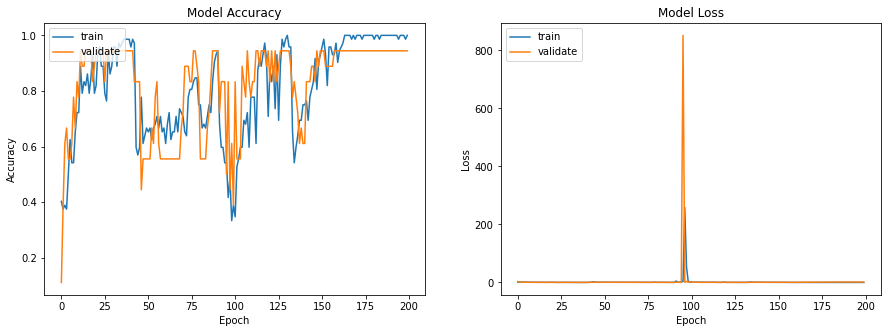

In [57]:
plotmodelhistory(log4)

<a id='11'></a>

## 11. Test in Real Time

In [40]:
from scipy import stats

In [41]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [1]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-60:]
        
        if len(sequence) == 60:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Dynamic sign langauge translator', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

NameError: name 'cv2' is not defined